# Pathways Toy Latency Analysis

Pathways is a commercial incremental dataflow tool. You specify a series of transformations as a graph and connect up a source and a sink. If the souce and the sink support streaming, e.g. files, Kafka queues, etc, then transformations are computed incrementally. It is also possible to run the graph in a batch mode for historical data. 

The compute engine of the library is written in Rust accessed via a Python API, which is a common architecture for Python libraries. Using Rust allows for fast computation in the critical path, and the usability of Python where speed is not necessary.

We have built a toy example that aggregates ticks across one second tumbling windows to test the latency cost of using Pathways. We use a Kafka queue to communicate between two Python process. The first process, called `tick_generator.py` generates ticks and places them on the Kafka queue with the topic 'ticks'. The second process in `agg_pw.py` is a Pathways dataflow which consumes the tick, aggregates it across a window, and submits the aggregation back onto the queue under the topic 'aggregations'. The first Python process polls for aggregation updates, and computes latency as the difference between the current time and the end of the window.

Aggregates are emitted for each tick received, which means Pathways will send an aggregate even if the window has not closed. If multiple ticks are received in a window then downstream components will receive multiple aggregations for the same window. It is up to downstream components to decide whether to act on the the update. For windowed aggregations Pathways allows the user to configure a cutoff where stats for the window are purged and any further ticks that fall in that window are ignored. Due to the incremental nature of Pathways will emit an update when it executes the cutoff.


In [2]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

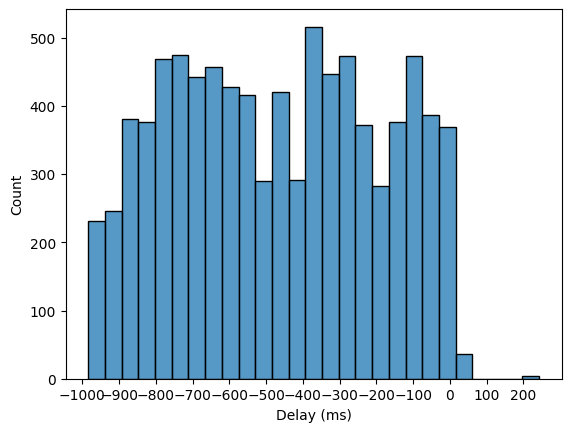

In [3]:
df = pl.read_ndjson("latency_pw.ndjson")
df = df.filter(pl.col("delay") < 10000)  # Remove all the updates due to cutoffs
df.describe()
sns.histplot(df, x="delay")
plt.xlabel("Delay (ms)")
plt.xticks(np.arange(-1000, 250, step=100))
plt.show()

In [5]:
df.filter(pl.col("delay") > 100)

symbol,delay,window_end,sum,count
str,f64,str,f64,f64
"""c""",238.24,"""2024-12-26T20:52:31+00:00""",2128.82,2.0
"""e""",241.327,"""2024-12-26T20:52:31+00:00""",2012.14,3.0
"""b""",241.474,"""2024-12-26T20:52:31+00:00""",2997.31,4.0
"""a""",242.449,"""2024-12-26T20:52:31+00:00""",140.11,1.0


The negative delays are from Pathways sending updates before the window is closed. The vast majority of messages arrive < 50ms from the closure of the window, yielding a large compute budget for alpha computation. There are 4 outliers where the delay > 200ms for the same window.

The delays could be due to the Pathways compute engine, the Kafka queue, or the interaction between the two. No tuning of config was attempted for this toy, and it might be possible to reduce the number of outliers and latency time overall.